Explain node 10: 100%|██████████| 200/200 [00:00<00:00, 265.59it/s]


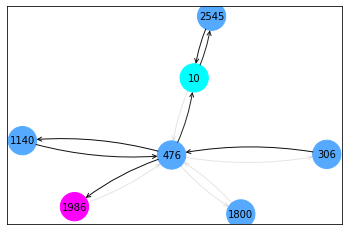

In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer, ARMAConv
from torch.nn import Sequential, Linear

dataset = 'Cora'
path = osp.join(osp.dirname(osp.realpath('__file__')), '..', 'data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin = Sequential(Linear(10, 10))
        self.conv1 = ARMAConv(dataset.num_features, 16, 2)
        self.conv2 = ARMAConv(16, dataset.num_classes, 2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

explainer = GNNExplainer(model, epochs=200)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)